In [1]:
# Image Captioning

# Steps

1. Data Collection
2. Understanding the data
3. Data Cleaning
4. Loading the training set
5. Data Preprocessing -- Images
6. Data Preprocessing -- Captions
7. Data Preparation using Generator Function
8. Word Embeddings
9. Model Architecture
10. Inference
11. Evaluation

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [106]:
# Reading the captions 

def readTextfile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [107]:
captions = readTextfile("Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [108]:
print(len(captions))

40460


In [109]:
# Dictionary to map each image with the list of captions

In [110]:
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
        
    descriptions[img_name].append(second)

In [111]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

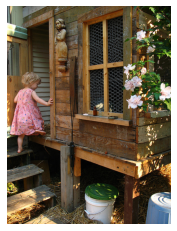

In [112]:
IMG_PATH = "Flickr_Data/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()


## Data Cleaning


In [113]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [114]:
clean_text("A cat is sitting over the house #64")

'cat is sitting over the house'

In [115]:
#Clean all Captions

for key, caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [116]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [117]:
# Write the data to a text file
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))


# Vocabulary

In [118]:
# Set of all unique words which the model can predict

descriptions = None
with open("descriptions.txt","r") as f:
    descriptions = f.read()
    

json_acceptable_string = descriptions.replace("'","\"")    
descriptions = json.loads(json_acceptable_string)

In [119]:
print(type(descriptions))

<class 'dict'>


In [120]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab Size : %d"%len(vocab))

Vocab Size : 8424


In [121]:
# Total no. of words across all the sentences

total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words : %d"%len(total_words))

Total Words : 373837


In [122]:
# Filter words from the vocab according to certain threshold frequency

import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [123]:
# Sorte this dictionary according to freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter 
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [124]:
print(len(total_words))

1845


# Prepare Test and Train Data

In [125]:
train_file_data = readTextfile("Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")

In [126]:
test_file_data = readTextfile("Flickr_data/Flickr_TextData/Flickr_8k.testImages.txt")

In [127]:
train = [row.split(".")[0] for row in train_file_data.split('\n')[:-1]]
test = [row.split(".")[0] for row in test_file_data.split('\n')[:-1]]

In [128]:
# Prepare the description for the training data
#Tweak - Add <s> and <e> token to our training data

train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [129]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# Transfer Learning 

- images -> Features
- text -> Features

In [130]:
# 1. Image Feature Extraction

model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [131]:
model_new = Model(model.input,model.layers[-2].output)

In [132]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    # Normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


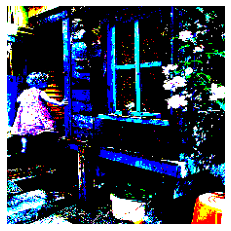

In [133]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [134]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [135]:
#encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

In [136]:
start = time()
encoding_train = {}
#image_id --> feature vector extracted from ResNet image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100 == 0:
        print("Encoding in Progress Time Step %d"%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time Step 0
Encoding in Progress Time Step 100
Encoding in Progress Time Step 200
Encoding in Progress Time Step 300
Encoding in Progress Time Step 400
Encoding in Progress Time Step 500
Encoding in Progress Time Step 600
Encoding in Progress Time Step 700
Encoding in Progress Time Step 800
Encoding in Progress Time Step 900
Encoding in Progress Time Step 1000
Encoding in Progress Time Step 1100
Encoding in Progress Time Step 1200
Encoding in Progress Time Step 1300
Encoding in Progress Time Step 1400
Encoding in Progress Time Step 1500
Encoding in Progress Time Step 1600
Encoding in Progress Time Step 1700
Encoding in Progress Time Step 1800
Encoding in Progress Time Step 1900
Encoding in Progress Time Step 2000
Encoding in Progress Time Step 2100
Encoding in Progress Time Step 2200
Encoding in Progress Time Step 2300
Encoding in Progress Time Step 2400
Encoding in Progress Time Step 2500
Encoding in Progress Time Step 2600
Encoding in Progress Time Step 2700
Enco

In [137]:
# Store everything to the disk //

with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [139]:
start = time()
encoding_test = {}
#image_id --> feature vector extracted from ResNet image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100 == 0:
        print("Encoding in Progress Time Step %d"%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time Step 0
Encoding in Progress Time Step 100
Encoding in Progress Time Step 200
Encoding in Progress Time Step 300
Encoding in Progress Time Step 400
Encoding in Progress Time Step 500
Encoding in Progress Time Step 600
Encoding in Progress Time Step 700
Encoding in Progress Time Step 800
Encoding in Progress Time Step 900
Total Time Taken : 117.29019618034363


In [140]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

# Data Preprocessing for Captions

In [142]:
#Vocab
len(total_words)

1845

In [143]:
word_to_idx = {}
idx_to_word = {}
for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i] = word

In [153]:
#print(word_to_idx["dog"])
print(len(idx_to_word))

1845


In [156]:
# Two special words 
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx)+1
print(vocab_size)

1848


In [158]:
max_len=0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


# Data Loader (Generator)

In [159]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n = 0
    while True:
        for key, desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    # 0 denotes padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n == batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    X1,X2,y = [],[],[]
                    n = 0

# Word Embeddings

In [161]:
f = open("glove.6B.50d.txt",encoding='utf8')

In [166]:
embedding_index = {}

for line in f:
    values = line.split()

    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [168]:
f.close()

In [169]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [176]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
    
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [178]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [181]:
#embedding_matrix[1847]

# Model Architecture

In [183]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)


In [185]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [186]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [188]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [189]:
# Important Thing - Preinitialize the Embedding Layer

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [190]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

# Training of Model

In [194]:
epochs = 20
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [209]:
def train():
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+ str(i)+'.h5')

In [210]:
model = load_model('model_9.h5')

## Predictions

In [211]:
def predict_caption(photo):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() 
        word = idx_to_word[ypred]
        in_text += (' '+word)
        
        if word == 'endseq':
            break
            
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

girl the player the near


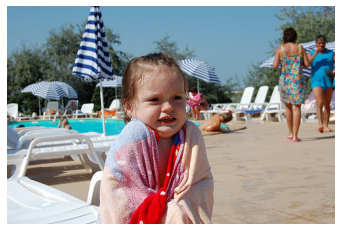

white with an looking with with black with black with black sea the red with black sea


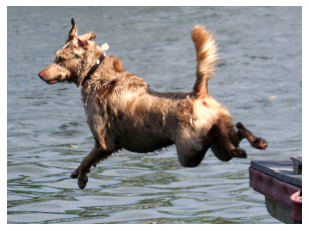

girl the two water


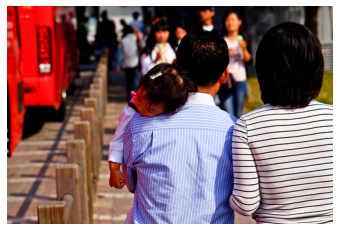

white with an looking people woman the off two running


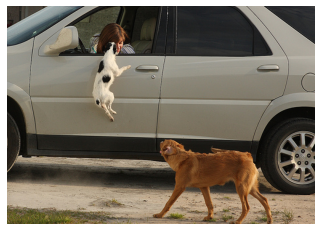

white with an looking with black dog woman the hangs


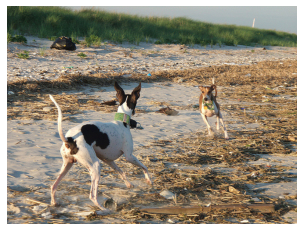

person the child the child the child the child the child the child the child the child the child the child the child the child the child the child the child the child the


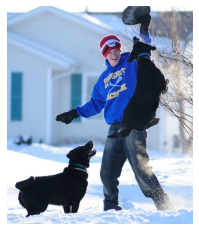

of water man and girl woman holding pool


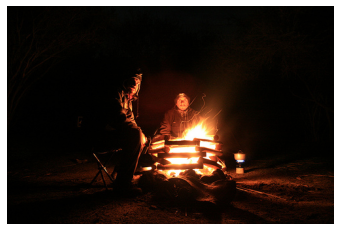

an ears with an looking field


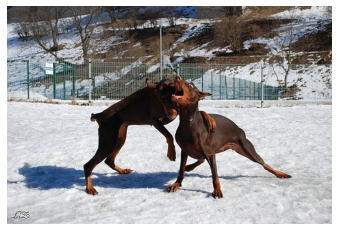

of relaxing six piece girls is stands the piece two piece girls


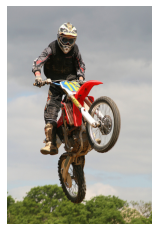

boy the little football little


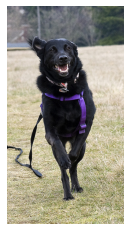

tan tan dog dog the two two off on on on on on on on on on on on on on on on on on on on on on on on on on on


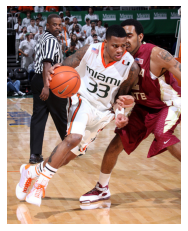

of enjoy calm on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on


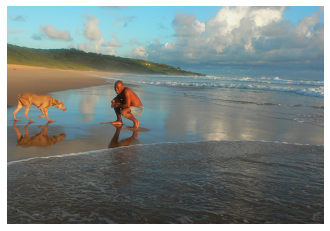

to woman and girl woman the red no puts


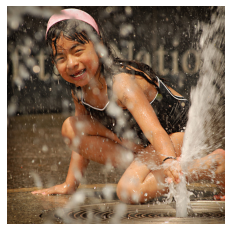

of of of of of of of of water


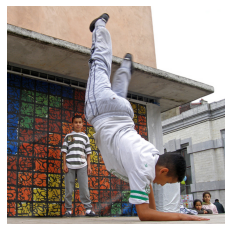

of of water


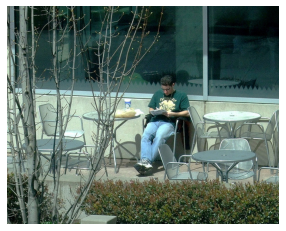

In [212]:
# Pick Some Random Images and See Results

for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Flickr_Data/Images/"+img_name+".jpg")
    caption = predict_caption(photo_2048)
    print(caption)
    plt.imshow(i)
    plt.axis('off')
    plt.show()